# **Reward Model Trainer**

**Author: Crescent - DSA4213 Group 18**

This notebook implements an end-to-end training pipeline for a Reward Model used in preference-based fine-tuning and reinforcement learning for language models.

The pipeline covers data preparation, tokenisation, model fine-tuning, validation, and visualisation of training dynamics (loss curves, accuracy, calibration, and risk analysis).

The workflow is modular:
- Configuration and reproducibility settings are defined upfront.
- Utilities handle data loading, batching, and logging.
- The training loop supports mixed precision, gradient scaling, and early stopping.
- Validation metrics and plots help assess both performance and calibration quality.

---
## **Table of Contents**
1. [Environment Setup](#env-setup)
2. [Imports](#imports)
3. [Configuration](#config)
4. [Utilities](#utils)
5. [Training & Validation](#train-val)
6. [Visualisations](#viz)

---
# 1. Environment Setup <a id='env-setup'></a>

Installs dependencies

In [2]:
!pip install pandas seaborn hf_transfer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 51.9 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 28.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [seaborn]m4/5 [seaborn]fer]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


# 2. Imports <a id='imports'></a>

In [1]:
from collections import Counter, defaultdict, OrderedDict
from pathlib import Path
from typing import Any, Dict, Tuple, List
import contextlib, glob, json, math, random, time, numpy as np, matplotlib.pyplot as plt
import torch, os, pandas as pd, seaborn as sns, torch.nn.functional as F
from torchinfo import summary
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer

/workspace/SelfTraining-Reward-MedQA-1/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 3. Configuration <a id='config'></a>
Set constants, hyperparameters, and paths.

In [2]:
# ╭────────────────────────────── Model & Directories ───────────────────────────────╮
MODEL_NAME = "meta-llama/Llama-3.2-3B-Instruct"

# Current and source directories
CUR_DIR = Path.cwd()
SRC_DIR = CUR_DIR.parent

# Data directories and files
DATA_DIR = SRC_DIR.parent / "data" / "processed"
PAIRS_PATH = DATA_DIR / "preference_pairs.json"
TRAIN_PATH = DATA_DIR / "preference_pairs_train.json"
VAL_PATH   = DATA_DIR / "preference_pairs_val.json"
TEST_PATH   = DATA_DIR / "preference_pairs_test.json"

# Checkpoint and metric directories
CKPT_DIR   = CUR_DIR / "checkpoints"
METRIC_DIR = CUR_DIR / "metrics"
VIZ_DIR    = METRIC_DIR / "Visualisations"
TRAIN_LOG = METRIC_DIR / "train_steps.jsonl"         # per-step loss
VAL_EPOCH_LOG = METRIC_DIR / "val_epochs.jsonl"      # per-epoch metrics
VAL_DELTAS_DIR = METRIC_DIR / "val_deltas"           # per-epoch margins for histogram
FINAL_SAVE_DIR = CUR_DIR / "save_model"

# Ensure directories exist
for p in (DATA_DIR, CKPT_DIR, METRIC_DIR, VIZ_DIR, VAL_DELTAS_DIR, FINAL_SAVE_DIR):
    p.mkdir(parents=True, exist_ok=True)

# ╭────────────────────────────── Training Config ──────────────────────────────╮
# Data split ratios
TRAIN_RATIO = 0.8
VAL_RATIO   = 0.1
TEST_RATIO  = 0.1

# Flags for data processing
DROP_WEAK = False   # Drop low-confidence preference pairs (set True for cleaner supervision)

# Hyperparameters
MAX_LEN    = 1024    # Maximum tokenised sequence length
BETA       = 3.0     # Scales confidence penalty into a sample weight
BATCH_SIZE = 2       # Training batch size
EPOCHS     = 5
GRAD_CLIP  = 1.0
LR         = 2e-5
WEIGHT_DECAY = 0.0

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# 4. Utilities <a id='utils'></a>
Helper functions for tokenisation, loss computation, logging, etc.

## JSON I/O

In [3]:
def _read_json(p: Path):
    return json.loads(p.read_text(encoding="utf-8"))

def _write_json(obj, p: Path):
    p.write_text(json.dumps(obj, indent=2, ensure_ascii=False), encoding="utf-8")
    print(f"[saved] {p}")

## Data splitting

In [5]:
def split_preference_pairs(
    pairs_path: Path,
    out_dir: Path,
    train_ratio: float = 0.8,
    val_ratio: float = 0.1,
    test_ratio: float = 0.1,
    seed: int = 42,
    drop_weak: bool = False,
    verbose: bool = True,   # flag to control debug printing
) -> Dict[str, Any]:
    """
    Split preference_pairs.json into train/val/test without question leakage.

    Stratification order:
      (1) majority risk_level per question_id
      (2) whether question_id contains any confidence_penalty != 0

    Ensures each question_id appears in exactly one split.
    Uses deterministic RNG for reproducibility.

    Args:
        pairs_path: path to preference_pairs.json
        out_dir: directory to write split files
        train_ratio, val_ratio, test_ratio: must sum to 1.0
        seed: RNG seed for reproducibility
        drop_weak: if True, drops pairs with score_difference==0 and pairs where both ratings == 1

    Writes:
        preference_pairs_train.json
        preference_pairs_val.json
        preference_pairs_test.json
        preference_pairs_split_stats.json

    Returns:
        stats dictionary with split counts, distributions, and integrity checks.
    """
    assert abs((train_ratio + val_ratio + test_ratio) - 1.0) < 1e-6, "Ratios must sum to 1.0"
    out_dir.mkdir(parents=True, exist_ok=True)

    def _rating_score(ans: Dict[str, Any]) -> int:
        # Prefer explicit numeric 'score'; fallback parse from 'rating' like "3-Incomplete"
        if "score" in ans and ans["score"] is not None:
            return int(ans["score"])
        r = ans.get("rating", "")
        return int(r[0]) if isinstance(r, str) and r[:1].isdigit() else -1  # -1 if unknown

    # Load data
    pairs = _read_json(pairs_path)
    if verbose:
        print(f"[INFO] Loaded {len(pairs):,} total pairs from {pairs_path.name}")

        # Check distinct question IDs in the loaded dataset
        qids_raw = {str(ex.get("question_id")).strip() for ex in pairs if ex.get("question_id")}
        print(f"[CHECK] Distinct question_id count: {len(qids_raw)}")

    # Optional filtering
    dropped = {"score_diff_zero": 0, "both_score1": 0} # counts how many pairs were removed for each reason
    clean = []
    if drop_weak:
        for ex in pairs:
            if ex.get("score_difference", None) == 0:
                dropped["score_diff_zero"] += 1
                continue
            sp = _rating_score(ex.get("preferred_answer", {}))
            sr = _rating_score(ex.get("rejected_answer", {}))
            if sp == 1 and sr == 1:
                dropped["both_score1"] += 1
                continue
            clean.append(ex) # only store if passes filters
    else:
        clean = pairs

    if verbose and drop_weak:
        print(f"[INFO] Dropped weak pairs: {sum(dropped.values())} "
              f"({dropped['score_diff_zero']} zero-diff, {dropped['both_score1']} both-score1)")

    # Group by question_id (no leakage across splits)
    by_qid = defaultdict(list)
    for ex in clean:
        qid = ex["question_id"]
        by_qid[qid].append(ex)

    qids = list(by_qid.keys())

    # local RNG (deterministic given seed)
    rng = random.Random(seed)
    rng.shuffle(qids)

    if verbose:
        print(f"[INFO] Total unique questions: {len(qids)}")
        print(f"[INFO] Random seed = {seed} (shuffling is deterministic)")

    # ---- derive question-level attributes ----
    def majority_risk(items: List[Dict[str, Any]]) -> str:
        """Get most frequent risk_level within a question."""
        return Counter(e.get("risk_level", "UNKNOWN") for e in items).most_common(1)[0][0]

    def has_conf_penalty(items: List[Dict[str, Any]]) -> bool:
        """Return True if any example under this question has confidence_penalty != 0."""
        for e in items:
            v = e.get("confidence_penalty", 0.0)
            try:
                if float(v) != 0.0:
                    return True
            except Exception:
                pass
        return False

    qid_risk, qid_flag, flagged_qids = {}, {}, []
    for q in qids:
        items = by_qid[q]
        qid_risk[q] = majority_risk(items)
        qid_flag[q] = has_conf_penalty(items)
        if qid_flag[q]:
            flagged_qids.append(q)

    # quick summary
    if verbose:
        risk_counts = Counter(qid_risk.values())
        print(f"[INFO] Risk-level distribution (questions): {dict(risk_counts)}")
        print(f"[INFO] Questions w/ confidence_penalty != 0: {len(flagged_qids)} "
              f"({len(flagged_qids)/len(qids):.1%})")
        
    # Stratify/bucket by (risk_level, has_conf_penalty)
    buckets: Dict[Tuple[str, bool], List[str]] = defaultdict(list)
    for q in qids:
        buckets[(qid_risk[q], qid_flag[q])].append(q)

    # ---- stratified split across buckets -----
    train_qids, val_qids, test_qids = set(), set(), set()
    for bucket_key, bucket in buckets.items():
        rng.shuffle(bucket)
        n = len(bucket)
        n_train = int(round(n * train_ratio))
        n_val = int(round(n * val_ratio))
        n_test = n - n_train - n_val
        train_qids.update(bucket[:n_train])
        val_qids.update(bucket[n_train:n_train + n_val])
        if test_ratio > 0:
            test_qids.update(bucket[n_train + n_val:])
        if verbose:
            risk, flag = bucket_key
            print(f"  [BUCKET] ({risk}, has_penalty={flag}) -> {n} qns "
                  f"=> train:{n_train}, val:{n_val}, test:{n_test}")

    # Materialise splits
    train_pairs = [e for q in train_qids for e in by_qid[q]]
    val_pairs   = [e for q in val_qids   for e in by_qid[q]]
    test_pairs  = [e for q in test_qids  for e in by_qid[q]] if test_ratio > 0 else []

    # ---- Check counts ----
    if verbose:
        total_pairs = len(train_pairs) + len(val_pairs) + len(test_pairs)
        print(f"[INFO] Final pair counts: train={len(train_pairs)}, val={len(val_pairs)}, test={len(test_pairs)}")
        print(f"[INFO] Total = {total_pairs} (from {len(clean)} original pairs)")
        print(f"[INFO] Unique QIDs per split -> "
              f"train:{len(train_qids)}, val:{len(val_qids)}, test:{len(test_qids)}")

    # ---- Verify no leakage ----
    overlap = (train_qids & val_qids) | (train_qids & test_qids) | (val_qids & test_qids)
    if verbose:
        if len(overlap) == 0:
            print("[CHECK] ✅ No question leakage between splits.")
        else:
            print(f"[CHECK] ⚠️ Leakage detected! {len(overlap)} overlapping QIDs!")

    # Save split sets
    _write_json(train_pairs, out_dir / "preference_pairs_train.json")
    _write_json(val_pairs,   out_dir / "preference_pairs_val.json")
    if test_ratio > 0:
        _write_json(test_pairs, out_dir / "preference_pairs_test.json")

    # ----- stats helpers -----
    def _risk_dist(lst):
        """Risk distribution (per-example)."""
        return dict(Counter(e.get("risk_level", "UNKNOWN") for e in lst))

    def _risk_dist_per_question(qset):
        """Risk distribution (per-question)."""
        c = Counter(qid_risk[q] for q in qset)
        return dict(c)

    def _flag_dist(lst):
        """Counts how many unique questions have vs. lack confidence penalties."""
        seen = set()
        cnt = Counter()
        for e in lst:
            q = e["question_id"]
            if q in seen:
                continue
            seen.add(q)
            cnt["has_conf_penalty" if qid_flag[q] else "no_conf_penalty"] += 1
        return dict(cnt)

    def _crosstab(lst):
        """Risk × penalty-flag counts (unique questions)."""
        seen = set()
        grid = defaultdict(lambda: Counter())
        for e in lst:
            q = e["question_id"]
            if q in seen:
                continue
            seen.add(q)
            grid[qid_risk[q]]["has" if qid_flag[q] else "none"] += 1
        return {r: {k: int(v) for k, v in c.items()} for r, c in grid.items()}

    # ---- integrity checks ----
    all_qids = set(qids)
    union_all = train_qids | val_qids | test_qids
    disjoint_ok = len((train_qids & val_qids) | (train_qids & test_qids) | (val_qids & test_qids)) == 0
    covered_ok = len(union_all) == len(all_qids)

    # ---- compile stats ----
    stats = {
        "seed": seed,
        "drop_weak": drop_weak,
        "dropped": dropped,
        "ratios": {"train": train_ratio, "val": val_ratio, "test": test_ratio},
        "counts": {
            "train": len(train_pairs),
            "val":   len(val_pairs),
            "test":  len(test_pairs),
        },
        "unique_qids": {
            "train": len(train_qids),
            "val":   len(val_qids),
            "test":  len(test_qids),
        },
        "risk_dist_example": {
            "train": _risk_dist(train_pairs),
            "val":   _risk_dist(val_pairs),
            "test":  _risk_dist(test_pairs),
        },
        "risk_dist_question": {
            "train": _risk_dist_per_question(train_qids),
            "val":   _risk_dist_per_question(val_qids),
            "test":  _risk_dist_per_question(test_qids),
        },
        "penalty_flag_dist": {
            "train": _flag_dist(train_pairs),
            "val":   _flag_dist(val_pairs),
            "test":  _flag_dist(test_pairs),
        },
        "risk_x_penalty_flag": {
            "train": _crosstab(train_pairs),
            "val":   _crosstab(val_pairs),
            "test":  _crosstab(test_pairs),
        },
        "flagged_qids": flagged_qids,
        "integrity_checks": {
            "disjoint_qids": disjoint_ok,
            "covered_qids": covered_ok,
        },
    }

    _write_json(stats, out_dir / "preference_pairs_split_stats.json")
    return stats

In [6]:
stats = split_preference_pairs(
    pairs_path = PAIRS_PATH,
    out_dir    = DATA_DIR,
    train_ratio= TRAIN_RATIO,
    val_ratio  = VAL_RATIO,
    test_ratio = TEST_RATIO,
    seed       = SEED,
    drop_weak  = DROP_WEAK, # change to True if want cleaner pairs
    verbose = True # change to false if don't want print msg
)
stats

[INFO] Loaded 31,102 total pairs from preference_pairs.json
[CHECK] Distinct question_id count: 103
[INFO] Total unique questions: 103
[INFO] Random seed = 42 (shuffling is deterministic)
[INFO] Risk-level distribution (questions): {'High Risk': 38, 'Low Risk': 26, 'Medium Risk': 39}
[INFO] Questions w/ confidence_penalty != 0: 90 (87.4%)
  [BUCKET] (High Risk, has_penalty=True) -> 35 qns => train:28, val:4, test:3
  [BUCKET] (Low Risk, has_penalty=True) -> 19 qns => train:15, val:2, test:2
  [BUCKET] (Medium Risk, has_penalty=True) -> 36 qns => train:29, val:4, test:3
  [BUCKET] (High Risk, has_penalty=False) -> 3 qns => train:2, val:0, test:1
  [BUCKET] (Low Risk, has_penalty=False) -> 7 qns => train:6, val:1, test:0
  [BUCKET] (Medium Risk, has_penalty=False) -> 3 qns => train:2, val:0, test:1
[INFO] Final pair counts: train=24970, val=3650, test=2482
[INFO] Total = 31102 (from 31102 original pairs)
[INFO] Unique QIDs per split -> train:82, val:11, test:10
[CHECK] ✅ No question leak

{'seed': 42,
 'drop_weak': False,
 'dropped': {'score_diff_zero': 0, 'both_score1': 0},
 'ratios': {'train': 0.8, 'val': 0.1, 'test': 0.1},
 'counts': {'train': 24970, 'val': 3650, 'test': 2482},
 'unique_qids': {'train': 82, 'val': 11, 'test': 10},
 'risk_dist_example': {'train': {'Medium Risk': 8469,
   'High Risk': 10728,
   'Low Risk': 5773},
  'val': {'Medium Risk': 1396, 'High Risk': 1313, 'Low Risk': 941},
  'test': {'High Risk': 1507, 'Medium Risk': 684, 'Low Risk': 291}},
 'risk_dist_question': {'train': {'Medium Risk': 31,
   'High Risk': 30,
   'Low Risk': 21},
  'val': {'Medium Risk': 4, 'High Risk': 4, 'Low Risk': 3},
  'test': {'High Risk': 4, 'Medium Risk': 4, 'Low Risk': 2}},
 'penalty_flag_dist': {'train': {'has_conf_penalty': 72,
   'no_conf_penalty': 10},
  'val': {'has_conf_penalty': 10, 'no_conf_penalty': 1},
  'test': {'has_conf_penalty': 8, 'no_conf_penalty': 2}},
 'risk_x_penalty_flag': {'train': {'Medium Risk': {'has': 29, 'none': 2},
   'High Risk': {'has': 28

In [4]:
# Load splits
train_pairs = _read_json(TRAIN_PATH)
val_pairs = _read_json(VAL_PATH)
len(train_pairs), len(val_pairs)

(24970, 3650)

## Dataset + Dataloader

In [6]:
# Load tokenizer (ensure PAD exists)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

In [7]:
def build_input(q, a):
    return f"Question:\n{q}\n\nAnswer:\n{a}"

# Dataset and collate
class PrefPairDataset(Dataset):
    def __init__(self, items):
        self.items = items
    def __len__(self):
        return len(self.items)
    def __getitem__(self, i):
        ex = self.items[i]
        x_pos = build_input(ex["question_text"], ex["preferred_answer"]["answer_text"])
        x_neg = build_input(ex["question_text"], ex["rejected_answer"]["answer_text"])
        pos = tokenizer(x_pos, truncation=True, max_length=MAX_LEN, return_tensors="pt")
        neg = tokenizer(x_neg, truncation=True, max_length=MAX_LEN, return_tensors="pt")
        w = 1.0 + BETA * float(ex.get("confidence_penalty", 0.0))
        risk = ex.get("risk_level", "UNKNOWN")
        return {"pos": pos, "neg": neg, "weight": torch.tensor(w, dtype=torch.float), "risk": risk}

def collate_fn(batch):
    def stack(side):
        ids  = [b[side]["input_ids"].squeeze(0) for b in batch]
        attn = [b[side]["attention_mask"].squeeze(0) for b in batch]
        ids  = torch.nn.utils.rnn.pad_sequence(ids,  batch_first=True, padding_value=tokenizer.pad_token_id)
        attn = torch.nn.utils.rnn.pad_sequence(attn, batch_first=True, padding_value=0)
        return {"input_ids": ids, "attention_mask": attn}
    weights = torch.stack([b["weight"] for b in batch])
    risks   = [b["risk"]   for b in batch]
    return {"pos": stack("pos"), "neg": stack("neg"), "weight": weights, "risk": risks}

# build loaders
train_loader = DataLoader(PrefPairDataset(train_pairs), batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(PrefPairDataset(val_pairs),   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
len(train_loader), len(val_loader)

(12485, 1825)

In [8]:
os.environ['HF_HUB_DISABLE_PROGRESS_BARS'] = '1'

# Also disable at the library level
from huggingface_hub.utils import are_progress_bars_disabled, disable_progress_bars
disable_progress_bars()

# Use 'dtype' instead of deprecated 'torch_dtype'
dtype = torch.float16 if torch.cuda.is_available() else torch.float32
device_map = "auto" if torch.cuda.is_available() else None
max_memory = {0: "13GB"} if torch.cuda.is_available() else None
reward_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=1,
    dtype=dtype,
    device_map=device_map,
    low_cpu_mem_usage=True,
    max_memory=max_memory
)

reward_model.config.pad_token_id = tokenizer.pad_token_id
reward_model = reward_model.float()  # Ensure model is in FP32

# align special tokens / training toggles
# reward_model.config.eos_token_id = tokenizer.eos_token_id
# reward_model.config.bos_token_id = getattr(tokenizer, "bos_token_id", tokenizer.eos_token_id)
# reward_model.config.use_cache = False  # safer during training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
reward_model = reward_model.to(device)

print("Device:", device)
print("Loaded:", MODEL_NAME)

Loading checkpoint shards: 100%|██████████| 2/2 [00:17<00:00,  8.94s/it]
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-3B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device: cuda
Loaded: meta-llama/Llama-3.2-3B-Instruct


## Check model architecture

In [ ]:
# Create dummy input with same dimensions as expected by model
batch_size = 1
seq_len = MAX_LEN

# Build synthetic data
dummy_input_ids = torch.randint(
    low=0,
    high=tokenizer.vocab_size,
    size=(batch_size, seq_len),
    dtype=torch.long
)
dummy_attention_mask = torch.ones((batch_size, seq_len), dtype=torch.long)

# Run summary (depth controls how detailed the nested layer view is)
summary(
    reward_model,
    input_data={
        "input_ids": dummy_input_ids,
        "attention_mask": dummy_attention_mask
    },
    col_names=["input_size", "output_size", "num_params", "trainable"],
    depth=3, # adjust depth for more/less detail
    row_settings=("var_names",),  # shows variable names per layer
)

In [ ]:
def _num_params(module):
    total = sum(p.numel() for p in module.parameters(recurse=False))
    train = sum(p.numel() for p in module.parameters(recurse=False) if p.requires_grad)
    return total, train

def _shape_str(x):
    if isinstance(x, torch.Tensor):
        return tuple(x.shape)
    if isinstance(x, (list, tuple)):
        # show first few shapes if it's a tuple/list
        parts = []
        for i, it in enumerate(x[:3]):
            if isinstance(it, torch.Tensor):
                parts.append(str(tuple(it.shape)))
            else:
                parts.append(type(it).__name__)
        if len(x) > 3:
            parts.append("...")
        return "[" + ", ".join(parts) + "]"
    return type(x).__name__

def model_summary(model, tokenizer, seq_len=64, verbose=True):
    """
    Prints a table:
      Layer (path) | Type | Output Shape | Param # (trainable)
    Uses a dummy forward pass with batch_size=1 and input length = seq_len.
    """
    device = next(model.parameters()).device
    dtype  = next(model.parameters()).dtype
    bytes_per = 2 if dtype in (torch.float16, torch.bfloat16) else 4

    # 1) Prepare a tiny dummy batch
    with torch.no_grad():
        toks = tokenizer("dummy", return_tensors="pt", add_special_tokens=True)
        # expand to desired seq_len (pad tokens)
        input_ids = torch.full((1, seq_len), fill_value=tokenizer.pad_token_id, dtype=torch.long)
        attn_mask = torch.zeros((1, seq_len), dtype=torch.long)
        # put some non-pad tokens at the start
        L = min(toks["input_ids"].shape[1], seq_len)
        input_ids[:, :L] = toks["input_ids"][:, :L]
        attn_mask[:, :L] = 1
        batch = {"input_ids": input_ids.to(device), "attention_mask": attn_mask.to(device)}

    # 2) Collect module info (param counts) and register forward hooks for output shapes
    names = {m: n for n, m in model.named_modules()}  # module -> qualified name
    layer_infos = OrderedDict() # preserve execution order
    handles = []

    def hook(module, inputs, outputs):
        name = names.get(module, module.__class__.__name__)
        if name == "": name = module.__class__.__name__
        if name not in layer_infos:
            p_total, p_train = _num_params(module)
            layer_infos[name] = {
                "type": module.__class__.__name__,
                "params": p_total,
                "trainable": p_train,
                "out": _shape_str(outputs),
            }

    # only hook leaf modules to avoid noisy duplicates
    for m in model.modules():
        is_leaf = len(list(m.children())) == 0
        if is_leaf:
            try:
                handles.append(m.register_forward_hook(hook))
            except Exception:
                pass

    # 3) Forward pass (to populate shapes)
    model.eval()
    with torch.no_grad():
        _ = model(**batch)

    for h in handles:
        h.remove()

    # 4) Print table
    total_params = sum(v["params"] for v in layer_infos.values())
    train_params = sum(v["trainable"] for v in layer_infos.values())
    frozen_params = total_params - train_params
    total_mb   = (total_params * bytes_per) / (1024**2)
    train_mb   = (train_params * bytes_per) / (1024**2)
    frozen_mb  = (frozen_params * bytes_per) / (1024**2)

    header = f"{'Layer (path)':60} {'Type':22} {'Output Shape':28} {'Param #':>12} {'Trainable':>10}"
    line   = "-" * len(header)
    if verbose:
        print(header)
        print(line)
        for name, info in layer_infos.items():
            print(f"{name:60} {info['type']:22} {str(info['out'])[:28]:28} {info['params']:12,} {info['trainable']:10,}")
        print(line)
        print(f"Total params:     {total_params:,}  (~{total_mb:.1f} MB at {str(dtype).replace('torch.','')})")
        print(f"Trainable params: {train_params:,}  (~{train_mb:.1f} MB)")
        print(f"Frozen params:    {frozen_params:,}  (~{frozen_mb:.1f} MB)")
        print(f"Seq len used for summary: {seq_len}, batch size: 1")

    # 5) Return a dict if you want to use programmatically
    return {
        "layers": layer_infos,
        "totals": {
            "total_params": total_params,
            "trainable_params": train_params,
            "frozen_params": frozen_params,
            "dtype": str(dtype),
            "mb_total": total_mb,
            "mb_trainable": train_mb,
            "mb_frozen": frozen_mb,
            "bytes_per_param": bytes_per,
            "seq_len": seq_len,
        }
    }

# run it
_ = model_summary(reward_model, tokenizer, seq_len=64)

In [9]:
# freeze/unfreeze helpers
# freeze all base layers, train only the classification head
def freeze_all_but_head(m):
    for p in m.parameters():
        p.requires_grad = False
    # common head names: 'score' (HF seq-classification), else 'classifier'
    head = getattr(m, "score", None) or getattr(m, "classifier", None)
    if head is not None:
        for p in head.parameters():
            p.requires_grad = True

# Usage:
freeze_all_but_head(reward_model)

In [ ]:
print("After freezing:")

# Run summary (depth controls how detailed the nested layer view is)
summary(
    reward_model,
    input_data={
        "input_ids": dummy_input_ids,
        "attention_mask": dummy_attention_mask
    },
    col_names=["input_size", "output_size", "num_params", "trainable"],
    depth=3, # adjust depth for more/less detail
    row_settings=("var_names",),  # shows variable names per layer
)

print("After freezing:")
_ = model_summary(reward_model, tokenizer, seq_len=64)

## Training step (pairwise Bradley-Terry loss)

In [10]:
def step_batch(model, batch):
    """
    Perform one training step using the pairwise Bradley-Terry (logistic) loss.
    
    Commonly used in Reward Model training for RLHF or preference learning, 
    where the model learns to assign higher scalar reqards to preferred samples 
    (positive responses) than to non-preferred ones (negative responses).
    
    Intuition:
    - For each (positive, negative) pair, compute the model scores:
        r_pos = model(preferred response)
        r_neg = model(non-preferred response)
    - The model should learn r_pos > r_neg.
    - The probability that the model ranks the positive higher is:
        P(pos > neg) = σ(r_pos - r_neg), where σ(x) is the sigmoid function.
    - The loss encourages this probability to be close to 1.

    Args:
        model: the reward model (a HF seq-classification model outputting scalar logits)
        batch: a dict with keys:
            - "pos": tokenized batch of preferred responses
            - "neg": tokenized batch of non-preferred responses
            - "weight": tensor of shape (B,) with sample weights (e.g., from confidence penalties)
    
    Returns:
        loss: the computed loss (a scalar tensor)
        delta: tensor of shape (B,) with r_pos - r_neg for each pair (detached from graph)
    """

    # Move all inputs to model device
    for side in ("pos","neg"):
        for k in batch[side]:
            batch[side][k] = batch[side][k].to(model.device)
    w = batch["weight"].to(model.device)

    # Forward pass: compute scalar rewards for positive and negative samples
    r_pos = model(**batch["pos"]).logits.squeeze(-1) # shape: (B,)
    r_neg = model(**batch["neg"]).logits.squeeze(-1) # shape: (B,)

    # Pairwise Bradley-Terry (logistic) loss
    delta = r_pos - r_neg
    loss_core = F.softplus(-delta) 
    loss = (w * loss_core).mean()
    return loss, delta.detach().cpu()

## Validation (pairwise accuracy + ECE)

In [11]:
def evaluate_riskwise(model, loader, bins=10):
    """
    Evaluate pairwise accuracy and calibration (ECE), and accuracy broken down by risk level.

    Pairwise setting:
    - The model outputs scalar rewards r(x). For each preference pair (pos, neg),
      compute delta = r_pos - r_neg and the probability p = σ(delta) that the positive
      item is preferred.
    
    Metrics:
    
    - Pairwise accuracy:
        acc = (1/N) * Σ 1{delta_i > 0}
        i.e., the fraction of pairs where r_pos > r_neg.
    
    - Expected Calibration Error (ECE):
        ECE = Σ_b (n_b / N) * | acc_b - conf_b |
      where for bin b:
        - n_b = number of samples in bin b
        - acc_b = average correctness in bin b
        - conf_b = average model confidence (p) in bin b
      Bins partition [0, 1] into `bins` equal-width intervals.
      Empty bins are skipped.
    
    - Accuracy by risk level (`acc_by_risk`):
        Dictionary mapping each risk bucket/value to its mean pairwise accuracy.

    Args:
        model: the reward model
        loader: DataLoader providing batches of preference pairs
        bins: number of bins for ECE calculation
    
    Returns:
        {
            "pairwise_accuracy": float,
            "ece": float,
            "acc_by_risk": Dict[Any, float],
            "ece_detail": {
                "bin_edges": np.ndarray,  # shape (bins+1,)
                "bin_counts": np.ndarray, # shape (bins,)
                "bin_acc": np.ndarray,    # shape (bins,)
                "bin_conf": np.ndarray,   # shape (bins,)
            },
            "deltas": np.ndarray,   # shape (N,), r_pos - r_neg for each pair
            "probs": np.ndarray,    # shape (N,), σ(delta)
            "corrects": np.ndarray, # shape (N,), 1 if delta>0 else 0
        }
    """
    model.eval()

    deltas_list = []
    probs_list = []
    corrects_list = []
    risks_all = []

    with torch.no_grad():
        for batch in loader:
            #  move inputs to model device
            for side in ("pos","neg"):
                for k in batch[side]:
                    batch[side][k] = batch[side][k].to(model.device)
            
            # Forward pass: compute scalar rewards for positive and negative samples
            r_pos = model(**batch["pos"]).logits.squeeze(-1) # shape: (B,)
            r_neg = model(**batch["neg"]).logits.squeeze(-1) # shape: (B,)
            
            # Pairwise probabilities and correctness labels
            delta = r_pos - r_neg
            p = torch.sigmoid(delta).cpu().numpy() # shape: (B,)
            c = (delta.cpu().numpy() > 0).astype(np.float32) # shape: (B,)

            deltas_list.append(delta.detach().cpu().numpy())
            probs_list.append(p)
            corrects_list.append(c)

            # Risks from collate_fn
            if "risk" in batch:
                risk_obj = batch["risk"]
                if isinstance(risk_obj, torch.Tensor):
                    risks_all.extend(risk_obj.detach().cpu().numpy().tolist())
                else:
                    risks_all.extend(list(risk_obj))

    # Concatenate
    if len(probs_list) == 0:
        # empty loader edge case
        return {
            "pairwise_accuracy": 0.0,
            "ece": 0.0,
            "acc_by_risk": {},
            "ece_detail": {
                "bin_edges": np.linspace(0.0, 1.0, bins + 1),
                "bin_counts": np.zeros(bins, dtype=int),
                "bin_acc": np.zeros(bins, dtype=float),
                "bin_conf": np.zeros(bins, dtype=float),
            },
            "deltas": np.array([], dtype=np.float32),
            "probs": np.array([], dtype=np.float32),
            "corrects": np.array([], dtype=np.float32),
        }
    
    deltas = np.concatenate(deltas_list).astype(np.float32)   # (N,)
    probs = np.concatenate(probs_list).astype(np.float32)     # (N,)
    corrects = np.concatenate(corrects_list).astype(np.float32)  # (N,)
    N = probs.shape[0]

    # Pairwise accuracy
    pairwise_acc = float(corrects.mean()) if N > 0 else 0.0

    # ECE bins (equal-width on [0,1])
    edges = np.linspace(0.0, 1.0, bins + 1)  # (bins+1,)
    # Map probs in [0,1] to bin ids 0..bins-1
    bin_ids = np.minimum((probs * bins).astype(int), bins - 1)

    bin_counts = np.bincount(bin_ids, minlength=bins).astype(np.int64)
    bin_correct_sum = np.bincount(bin_ids, weights=corrects, minlength=bins).astype(np.float64)
    bin_conf_sum = np.bincount(bin_ids, weights=probs, minlength=bins).astype(np.float64)

    # Averages per bin; avoid divide-by-zero
    bin_acc = np.divide(
        bin_correct_sum, bin_counts,
        out=np.zeros_like(bin_correct_sum, dtype=np.float64),
        where=bin_counts > 0
    )
    bin_conf = np.divide(
        bin_conf_sum, bin_counts,
        out=np.zeros_like(bin_conf_sum, dtype=np.float64),
        where=bin_counts > 0
    )

    nonempty = bin_counts > 0
    ece = float(np.sum((bin_counts[nonempty] / max(N, 1)) * np.abs(bin_acc[nonempty] - bin_conf[nonempty])))

    # Accuracy by risk level
    acc_by_risk = {}
    if len(risks_all) == N and N > 0:
        # Handle mixed types by unique() on array of objects
        unique_risks = sorted(set(risks_all), key=lambda x: str(x))
        for r in unique_risks:
            idx = np.fromiter((rr == r for rr in risks_all), dtype=bool, count=N)
            if idx.any():
                acc_by_risk[r] = float(corrects[idx].mean())

    return {
        "pairwise_accuracy": pairwise_acc,
        "ece": ece,
        "acc_by_risk": acc_by_risk,
        "ece_detail": {
            "bin_edges": edges,
            "bin_counts": bin_counts,
            "bin_acc": bin_acc,
            "bin_conf": bin_conf,
        },
        "deltas": deltas,
        "probs": probs,
        "corrects": corrects,
    }

## Saving/logging functions

In [12]:
def save_ckpt(model, sub="epoch"): # sub: subdirectory name
    out = CKPT_DIR / sub
    out.mkdir(parents=True, exist_ok=True)
    tokenizer.save_pretrained(out); model.save_pretrained(out)
    print(f"[saved] {out}")

def log_train_step(step:int, loss:float, epoch:int):
    with TRAIN_LOG.open("a", encoding="utf-8") as f:
        f.write(json.dumps({"ts": time.time(), "step": step, "epoch": epoch, "loss": float(loss)}) + "\n")

def log_val_epoch(epoch:int, metrics:dict):
    def make_serializable(obj):
        if hasattr(obj, 'tolist'):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {k: make_serializable(v) for k, v in obj.items()}
        elif isinstance(obj, (list, tuple)):
            return [make_serializable(item) for item in obj]
        elif isinstance(obj, (np.floating, np.integer)):
            return float(obj)
        else:
            return obj

    rec = {"ts": time.time(), "epoch": epoch, **make_serializable(metrics)}
    with VAL_EPOCH_LOG.open("a", encoding="utf-8") as f:
        f.write(json.dumps(rec) + "\n")

def dump_val_deltas(epoch:int, deltas:list[float]):
    out = VAL_DELTAS_DIR / f"deltas_epoch{epoch:02d}.json"
    # Convert to list if it's an array/tensor
    if hasattr(deltas, 'tolist'):
        deltas = deltas.tolist()
    out.write_text(json.dumps({"epoch": epoch, "deltas": deltas}), encoding="utf-8")
    return out

def save_metrics(d: dict, name: str):
    p = METRIC_DIR / name
    
    def make_serializable(obj):
        """Recursively convert numpy arrays and tensors to JSON-serializable types."""
        if hasattr(obj, 'tolist'):  # numpy array or torch tensor
            return obj.tolist()
        elif isinstance(obj, dict):
            return {k: make_serializable(v) for k, v in obj.items()}
        elif isinstance(obj, (list, tuple)):
            return [make_serializable(item) for item in obj]
        elif isinstance(obj, (np.floating, np.integer)):
            return float(obj)
        else:
            return obj
    
    d_serializable = make_serializable(d)
    p.write_text(json.dumps(d_serializable, indent=2), encoding="utf-8")
    print(f"[saved] {p}")

# 5. Training & Validation <a id='train-val'></a>
Training loop, evaluation metrics, checkpoints, and logging.

In [13]:
# Optimiser & AMP (automatic mixed precision) setup
optim = AdamW(reward_model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
use_cuda = torch.cuda.is_available()
scaler = torch.amp.GradScaler(enabled=use_cuda)

# Early stopping targets: maximise pairwise accuracy, minimise ECE
patience, since_best = 2, 0
best_score = (-1.0, float("inf"))
global_step = 0

for epoch in range(1, EPOCHS+1):
    reward_model.train()
    pbar = tqdm(train_loader, desc=f"epoch {epoch}")

    for batch in pbar:
        optim.zero_grad(set_to_none=True)

        # autocast only on CUDA
        ctx = (torch.amp.autocast(device_type='cuda', enabled=True) if use_cuda
               else contextlib.nullcontext())  # disable on CPU
        with ctx:
            # Pairwise Bradley-Terry (logistic) loss
            loss, _ = step_batch(reward_model, batch) # returns (loss, delta_cpu)
        
        # backprop with gradient scaling
        scaler.scale(loss).backward()

        # unscale before clipping so clipping is applied on real magnitudes
        scaler.unscale_(optim)
        torch.nn.utils.clip_grad_norm_(reward_model.parameters(), GRAD_CLIP)

        # optimiser step through the scaler, then update scale for next iteration
        scaler.step(optim)
        scaler.update()

        # logging per step
        pbar.set_postfix(loss=f"{loss.item():.4f}")
        global_step += 1
        log_train_step(global_step, loss.item(), epoch)

    # Validation & compute metrics
    val_metrics = evaluate_riskwise(reward_model, val_loader, bins=10)
    all_deltas = val_metrics.pop("deltas")  # Remove deltas from dict and store separately

    # Now val_metrics doesn't contain deltas, safe to serialize
    save_metrics(val_metrics, f"reward_eval_val_epoch{epoch:02d}.json")
    log_val_epoch(epoch, val_metrics)
    dump_val_deltas(epoch, all_deltas)
    print(f"val (epoch {epoch}): {val_metrics['pairwise_accuracy']:.4f}, ECE={val_metrics['ece']:.4f}")

    # Model selection & early stopping
    # Prefer higher accuracy and lower ECE; compare via (acc, -ece)
    score = (val_metrics["pairwise_accuracy"], -val_metrics["ece"])
    if score > best_score:
        best_score = score
        save_ckpt(reward_model, sub="best")
        since_best = 0
    else:
        since_best += 1
        if since_best >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
     
    # Always keep a per-epoch checkpoint for traceability
    save_ckpt(reward_model, sub=f"epoch{epoch:02d}")

epoch 1: 100%|██████████| 12485/12485 [19:20<00:00, 10.76it/s, loss=1.6715]


[saved] /workspace/SelfTraining-Reward-MedQA-1/src/reward_model/metrics/reward_eval_val_epoch01.json
val (epoch 1): 0.5907, ECE=0.2448
[saved] /workspace/SelfTraining-Reward-MedQA-1/src/reward_model/checkpoints/best
[saved] /workspace/SelfTraining-Reward-MedQA-1/src/reward_model/checkpoints/epoch01


epoch 2: 100%|██████████| 12485/12485 [18:50<00:00, 11.04it/s, loss=0.0679]


[saved] /workspace/SelfTraining-Reward-MedQA-1/src/reward_model/metrics/reward_eval_val_epoch02.json
val (epoch 2): 0.6074, ECE=0.2168
[saved] /workspace/SelfTraining-Reward-MedQA-1/src/reward_model/checkpoints/best
[saved] /workspace/SelfTraining-Reward-MedQA-1/src/reward_model/checkpoints/epoch02


epoch 3: 100%|██████████| 12485/12485 [19:10<00:00, 10.85it/s, loss=0.5669]


[saved] /workspace/SelfTraining-Reward-MedQA-1/src/reward_model/metrics/reward_eval_val_epoch03.json
val (epoch 3): 0.6096, ECE=0.2049
[saved] /workspace/SelfTraining-Reward-MedQA-1/src/reward_model/checkpoints/best
[saved] /workspace/SelfTraining-Reward-MedQA-1/src/reward_model/checkpoints/epoch03


epoch 4: 100%|██████████| 12485/12485 [19:18<00:00, 10.77it/s, loss=0.0059]


[saved] /workspace/SelfTraining-Reward-MedQA-1/src/reward_model/metrics/reward_eval_val_epoch04.json
val (epoch 4): 0.6142, ECE=0.1907
[saved] /workspace/SelfTraining-Reward-MedQA-1/src/reward_model/checkpoints/best
[saved] /workspace/SelfTraining-Reward-MedQA-1/src/reward_model/checkpoints/epoch04


epoch 5: 100%|██████████| 12485/12485 [19:04<00:00, 10.91it/s, loss=0.0143]


[saved] /workspace/SelfTraining-Reward-MedQA-1/src/reward_model/metrics/reward_eval_val_epoch05.json
val (epoch 5): 0.6123, ECE=0.1819
[saved] /workspace/SelfTraining-Reward-MedQA-1/src/reward_model/checkpoints/epoch05


## Save model and tokenizer

In [14]:
# Save both model and tokenizer in Hugging Face format
print(f"Saving model and tokenizer to src/reward_model/save_model folder.")
reward_model.save_pretrained(FINAL_SAVE_DIR)
tokenizer.save_pretrained(FINAL_SAVE_DIR)

Saving model and tokenizer to src/reward_model/save_model folder.


('/workspace/SelfTraining-Reward-MedQA-1/src/reward_model/save_model/tokenizer_config.json',
 '/workspace/SelfTraining-Reward-MedQA-1/src/reward_model/save_model/special_tokens_map.json',
 '/workspace/SelfTraining-Reward-MedQA-1/src/reward_model/save_model/chat_template.jinja',
 '/workspace/SelfTraining-Reward-MedQA-1/src/reward_model/save_model/tokenizer.json')

## Reload model and tokenizer

In [15]:
# To reload model and tokenizer

# tokenizer = AutoTokenizer.from_pretrained(FINAL_SAVE_DIR)
# model = AutoModelForSequenceClassification.from_pretrained(FINAL_SAVE_DIR)
# model.eval()

# print("Model successfully loaded for evaluation!")

# 6. Visualisations <a id='viz'></a>

In [16]:
sns.set_style("whitegrid")

## Training Loss by Steps (Smoothed)

In [17]:
# Load training step logs
rows = [json.loads(l) for l in open(METRIC_DIR / "train_steps.jsonl", "r", encoding="utf-8")]
df_train_steps = pd.DataFrame(rows).sort_values("ts") # chronological order

# Detect run boundaries whenever step decreases (new run started)
run = [1]
for i in range(1, len(df_train_steps)):
    run.append(run[-1] + 1 if df_train_steps.iloc[i]["step"] < df_train_steps.iloc[i-1]["step"] else run[-1])
df_train_steps["run_id"] = run

print("Detected runs:", df_train_steps["run_id"].nunique())
summary = (df_train_steps.groupby("run_id")
             .agg(first_step=("step","min"),
                  last_step=("step","max"),
                  first_epoch=("epoch","min"),
                  last_epoch=("epoch","max"),
                  n_records=("step","size"),
                  loss_start=("loss", lambda x: np.mean(x.head(200))),
                  loss_end=("loss", lambda x: np.mean(x.tail(200)))))
print(summary)

Detected runs: 1
        first_step  last_step  first_epoch  last_epoch  n_records  loss_start  \
run_id                                                                          
1                1      62425            1           5      62425    0.962133   

        loss_end  
run_id            
1       0.579348  


In [18]:
latest_run = df_train_steps["run_id"].max()
df_train_steps_latest_run = df_train_steps[df_train_steps["run_id"] == latest_run].copy()
print(f"Keeping run_id={latest_run} \n"
      f"({len(df_train_steps_latest_run)} records, steps {df_train_steps_latest_run['step'].min()} to {df_train_steps_latest_run['step'].max()}).")

# Backup old log and overwrite with only latest run
backup = TRAIN_LOG.with_suffix(".jsonl.bak")
backup.write_text("\n".join(json.dumps(r) for r in rows), encoding="utf-8")

TRAIN_LOG.write_text(
    "\n".join(json.dumps({k: v for k, v in rec.items() if k != "run_id"}) for rec in df_train_steps_latest_run.to_dict("records")),
    encoding="utf-8"
)
print(f"Backed up full log to: src/reward_model/metrics/train_steps.jsonl.bak")
print(f"Wrote latest run only to: src/reward_model/metrics/train_steps.jsonl")

# Use this for plotting below
df_train_steps = df_train_steps_latest_run.reset_index(drop=True)

Keeping run_id=1 
(62425 records, steps 1 to 62425).


Backed up full log to: src/reward_model/metrics/train_steps.jsonl.bak
Wrote latest run only to: src/reward_model/metrics/train_steps.jsonl


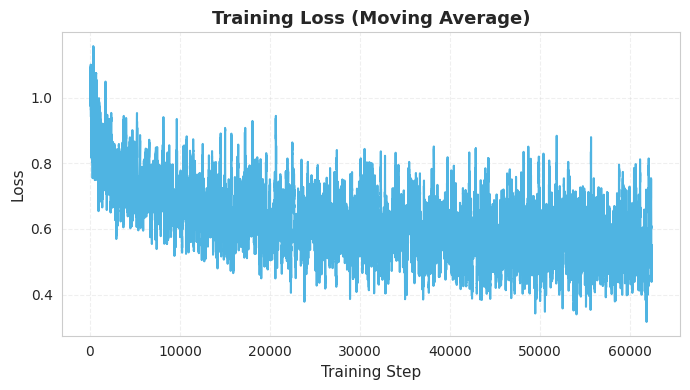

Plot saved to src/reward_model/Visualisations folder!


In [19]:
# inline moving average
def _moving_avg(x, w=50):
    if len(x) < w: 
        return np.array(x, dtype=float)
    c = np.cumsum(np.insert(x, 0, 0.0))
    return (c[w:] - c[:-w]) / float(w)

W = 50
steps = df_train_steps["step"].to_numpy()
losses = df_train_steps["loss"].to_numpy()
losses_smooth = _moving_avg(losses, w=W)

plt.figure(figsize=(7,4))
plt.plot(steps[W-1:], losses_smooth, color="#4fb4e2", label="Train Loss (Smoothed)")
plt.title("Training Loss (Moving Average)", fontsize=13, weight="bold")
plt.xlabel("Training Step", fontsize=11)
plt.ylabel("Loss", fontsize=11)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()

save_path = VIZ_DIR / "train_loss_by_step.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Plot saved to src/reward_model/Visualisations folder!")

## Training VS Validation Loss by Epoch

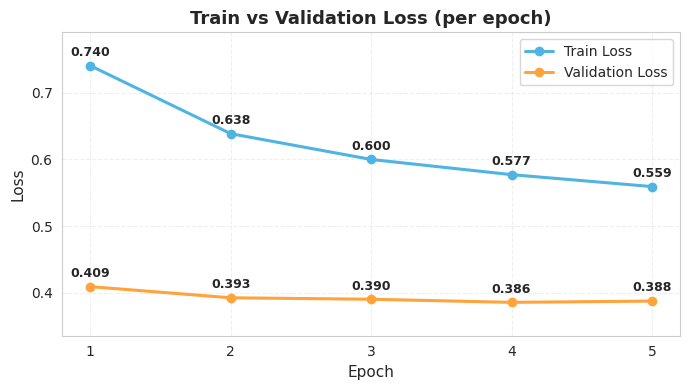

Plot saved to src/reward_model/Visualisations folder!


In [20]:
# Aggregate train loss per epoch from JSONL
epoch_sum, epoch_cnt = {}, {}
with open(METRIC_DIR / "train_steps.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        rec = json.loads(line)
        ep, loss = int(rec["epoch"]), float(rec["loss"])
        epoch_sum[ep] = epoch_sum.get(ep, 0.0) + loss
        epoch_cnt[ep] = epoch_cnt.get(ep, 0) + 1

train_epochs = sorted(epoch_sum.keys())
train_epoch_loss = [epoch_sum[ep] / epoch_cnt[ep] for ep in train_epochs] # average loss per epoch

# Load validation (use real val_loss if logged; else proxy from accuracy)
val_epochs, val_losses = [], []
for jpath in sorted(METRIC_DIR.glob("reward_eval_val_epoch*.json")):
    with open(jpath, "r", encoding="utf-8") as f:
        rec = json.load(f)
    ep = int(jpath.stem.split("epoch")[-1])
    if "val_loss" in rec:
        vloss = float(rec["val_loss"])
    else:
        # proxy if didn't log val loss
        vloss = 1.0 - float(rec["pairwise_accuracy"])
    val_epochs.append(ep)
    val_losses.append(vloss)

plt.figure(figsize=(7,4))
plt.plot(
    train_epochs, train_epoch_loss, 
    color="#4fb4e2", marker="o", markersize=6,
    linewidth=2.2, label="Train Loss"
)

if val_losses:
    plt.plot(
        val_epochs, val_losses, 
        color="#ffa33a", marker="o", markersize=6,
        linewidth=2.2, label="Validation Loss"
    )

# Annotate each point with its value
for x, y in zip(train_epochs, train_epoch_loss):
    plt.text(x, y+0.01, f"{y:.3f}", ha='center', va='bottom',
             fontsize=9, weight="bold")

for x, y in zip(val_epochs, val_losses):
    plt.text(x, y+0.01, f"{y:.3f}", ha='center', va='bottom',
             fontsize=9, weight="bold")

plt.title("Train vs Validation Loss (per epoch)", fontsize=13, weight="bold")
plt.xlabel("Epoch", fontsize=11)
plt.ylabel("Loss", fontsize=11)
plt.xticks(range(1, max(train_epochs) + 1))
plt.ylim(min(val_losses)-0.05, max(train_epoch_loss) + 0.05)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()

save_path = VIZ_DIR / "train_val_loss_by_epoch.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Plot saved to src/reward_model/Visualisations folder!")

## Validation Pairwaise Accuracy & ECE (By Epoch)

Validation log is clean (1 entry per epoch).
Loaded 5 epochs: [1, 2, 3, 4, 5]


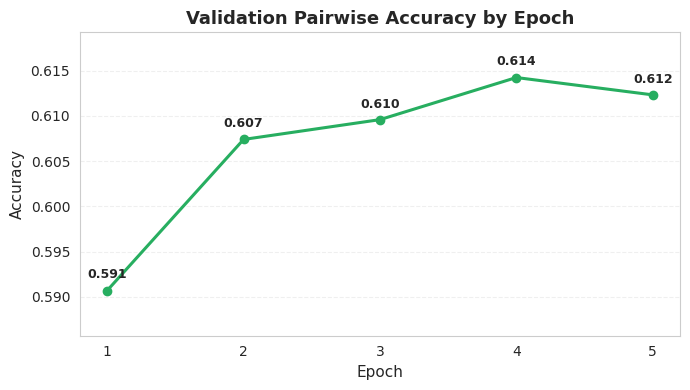

Plot saved to src/reward_model/Visualisations folder!


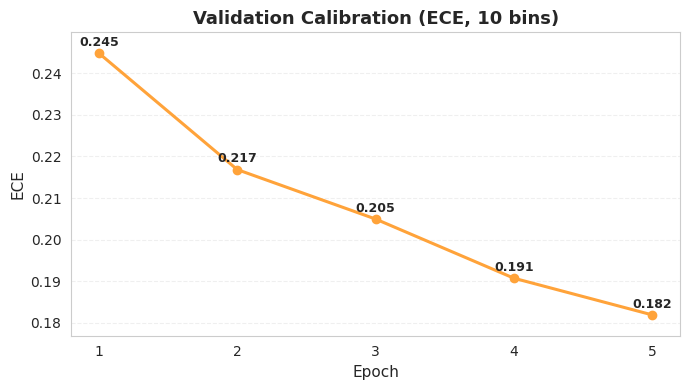

Plot saved to src/reward_model/Visualisations folder!


In [21]:
records = []
with open(METRIC_DIR / "val_epochs.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        rec = json.loads(line)
        records.append(rec)

df_val_epochs = pd.DataFrame(records)

# Ensure epoch is numeric
df_val_epochs["epoch"] = df_val_epochs["epoch"].astype(int)

# Sort by epoch and timestamp if available
if "ts" in df_val_epochs.columns:
    df_val_epochs = df_val_epochs.sort_values(["epoch", "ts"])
else:
    df_val_epochs = df_val_epochs.sort_values("epoch")

# Drop duplicate epochs, keep only the last logged entry
df_val_epochs = df_val_epochs.drop_duplicates(subset=["epoch"], keep="last").reset_index(drop=True)

# Sanity check for duplicates
dupes = df_val_epochs["epoch"].duplicated(keep=False)
if dupes.any():
    duped_epochs = df_val_epochs.loc[dupes, "epoch"].unique().tolist()
    print(f"Found duplicate entries for epochs: {duped_epochs}")
else:
    print("Validation log is clean (1 entry per epoch).")

# Extract for plotting
epochs = df_val_epochs["epoch"].tolist()
accs   = df_val_epochs["pairwise_accuracy"].astype(float).tolist()
eces   = df_val_epochs["ece"].astype(float).tolist()

print(f"Loaded {len(epochs)} epochs: {epochs}")

# Validation pairwise accuracy by epoch
plt.figure(figsize=(7,4))
plt.plot(
    epochs, accs,
    color="#27ae60", marker="o", markersize=6, 
    linewidth=2.2, label="Accuracy"
)
# Annotate each point with its value
for x, y in zip(epochs, accs):
    plt.text(x, y + 0.001, f"{y:.3f}", ha='center', va='bottom',
             fontsize=9, weight="bold")

plt.title("Validation Pairwise Accuracy by Epoch", fontsize=13, weight="bold")
plt.xlabel("Epoch", fontsize=11)
plt.ylabel("Accuracy", fontsize=11)
plt.xticks(epochs)
plt.ylim(min(accs)-0.005, max(accs)+0.005) # add some headroom
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.grid(axis="x", visible=False)
plt.tight_layout()

save_path = VIZ_DIR / "val_accuracy_by_epoch.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Plot saved to src/reward_model/Visualisations folder!")

# Validation ECE by epoch
plt.figure(figsize=(7,4))
plt.plot(
    epochs, eces,
    color="#ffa33a", marker="o", markersize=6, 
    linewidth=2.2, label="ECE"
)
# Annotate each point with its value
for x, y in zip(epochs, eces):
    plt.text(x, y + 0.001, f"{y:.3f}", ha='center', va='bottom',
             fontsize=9, weight="bold")
    
plt.title("Validation Calibration (ECE, 10 bins)", fontsize=13, weight="bold")
plt.xlabel("Epoch", fontsize=11)
plt.ylabel("ECE", fontsize=11)
plt.xticks(epochs)
plt.ylim(min(eces)-0.005, max(eces)+0.005)  # add some headroom
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.grid(axis="x", visible=False)
plt.tight_layout()

save_path = VIZ_DIR / "val_ece_by_epoch.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Plot saved to src/reward_model/Visualisations folder!")

## Accuracy by Risk (Latest Epoch)

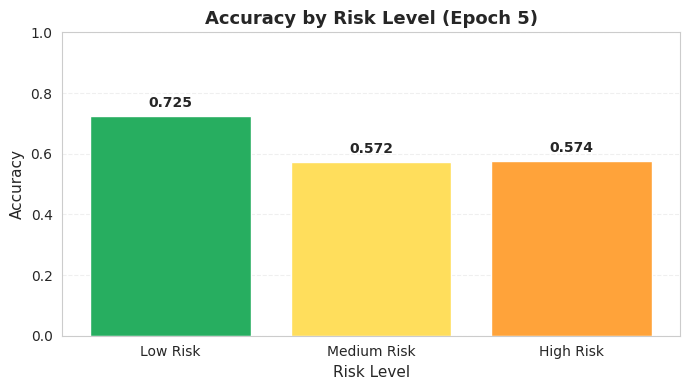

Plot saved to src/reward_model/Visualisations folder!


In [22]:
# Check if acc_by_risk exists
if "acc_by_risk" not in df_val_epochs.columns or df_val_epochs["acc_by_risk"].isna().all():
    raise ValueError("No accuracy-by-risk data found in val_epochs.jsonl.")

# Get the latest record
if "ts" in df_val_epochs.columns:
    last_row = df_val_epochs.sort_values(["epoch", "ts"]).iloc[-1]
else:
    last_row = df_val_epochs.sort_values("epoch").iloc[-1]

acc_by_risk = last_row.get("acc_by_risk", {})

# Ensure desired display order
order = ["Low Risk", "Medium Risk", "High Risk"]
labels = [label for label in order if label in acc_by_risk]
vals = [acc_by_risk[label] for label in labels]

# Plot
plt.figure(figsize=(7,4))
colours = ['#27ae60', "#ffde5c", '#ffa33a'] # Colour palette (green, yellow, orange)
bars = plt.bar(labels, vals, color=colours)

# Annotate values above bars
for i, value in enumerate(vals):
    plt.text(i, value + 0.02, f"{value:.3f}", ha='center', va='bottom', fontsize=10, weight="bold")

plt.title(f"Accuracy by Risk Level (Epoch {int(last_row['epoch'])})", fontsize=13, weight="bold")
plt.xlabel("Risk Level", fontsize=11)
plt.ylabel("Accuracy", fontsize=11)
plt.ylim(0, 1.00)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.grid(axis="x", visible=False)
plt.tight_layout()

save_path = VIZ_DIR / f"accuracy_by_risk_epoch{int(last_row['epoch']):02d}.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Plot saved to src/reward_model/Visualisations folder!")

## Validation Δ = r_pos - r_neg Histogram (Latest Epoch)

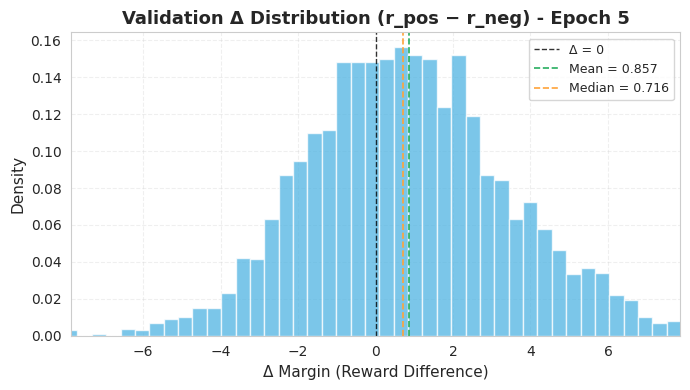

Plot saved to src/reward_model/Visualisations folder!


In [23]:
# Load the latest delta file
delta_files = sorted(glob.glob(str(VAL_DELTAS_DIR / "deltas_epoch*.json")))
if not delta_files:
    raise FileNotFoundError(f"No delta files found in: {VAL_DELTAS_DIR}")

with open(delta_files[-1], "r", encoding="utf-8") as f:
    rec = json.load(f)

deltas = rec.get("deltas", [])
epoch = rec.get("epoch", "unknown")

# Compute stats
mean_delta = float(np.mean(deltas))
median_delta = float(np.median(deltas))
std_delta = float(np.std(deltas))

# Plot histogram of Δ margins
plt.figure(figsize=(7,4))
n, bins, patches = plt.hist(
    deltas,
    bins=50,
    density=True, # normalise to density so shape is clearer
    color="#4fb4e2",
    alpha=0.75
)

# Vertical reference lines
plt.axvline(0, color="black", linestyle="--", linewidth=1, alpha=0.8, label="Δ = 0")
plt.axvline(mean_delta, color="#27ae60", linestyle="--", linewidth=1.2, label=f"Mean = {mean_delta:.3f}")
plt.axvline(median_delta, color="#ffa33a", linestyle="--", linewidth=1.2, label=f"Median = {median_delta:.3f}")

# Titles and labels
plt.title(f"Validation Δ Distribution (r_pos − r_neg) - Epoch {epoch}", fontsize=13, weight="bold")
plt.xlabel("Δ Margin (Reward Difference)", fontsize=11)
plt.ylabel("Density", fontsize=11)

# X-axis symmetric around 0 for easier interpretation
lim = np.percentile(np.abs(deltas), 99)
plt.xlim(-lim, lim)

# Grid and aesthetics
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(fontsize=9)
plt.tight_layout()

save_path = VIZ_DIR / f"val_deltas_hist_epoch{epoch:02d}.png"
plt.savefig(save_path, dpi=300)
plt.show()
print(f"Plot saved to src/reward_model/Visualisations folder!")